In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Thêm thư viện

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from imutils import paths
from keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.layers import Input
from keras.models import Model
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Flatten
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf

In [ ]:
!unzip "/content/drive/MyDrive/Dataset_resized_2.0.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Dataset_resized_2.0/G_M/20210210_112040.jpg  
  inflating: __MACOSX/Dataset_resized_2.0/G_M/._20210210_112040.jpg  
  inflating: Dataset_resized_2.0/G_M/glass100.jpg  
  inflating: __MACOSX/Dataset_resized_2.0/G_M/._glass100.jpg  
  inflating: Dataset_resized_2.0/G_M/metal150.jpg  
  inflating: __MACOSX/Dataset_resized_2.0/G_M/._metal150.jpg  
  inflating: Dataset_resized_2.0/G_M/20210222_184153.jpg  
  inflating: __MACOSX/Dataset_resized_2.0/G_M/._20210222_184153.jpg  
  inflating: Dataset_resized_2.0/G_M/metal144.jpg  
  inflating: __MACOSX/Dataset_resized_2.0/G_M/._metal144.jpg  
  inflating: Dataset_resized_2.0/G_M/20210204_012127.jpg  
  inflating: __MACOSX/Dataset_resized_2.0/G_M/._20210204_012127.jpg  
  inflating: Dataset_resized_2.0/G_M/20210222_183600.jpg  
  inflating: __MACOSX/Dataset_resized_2.0/G_M/._20210222_183600.jpg  
  inflating: Dataset_resized_2.0/G_M/received_485603355953339.jpg  
  inflating: __MACOS

3495


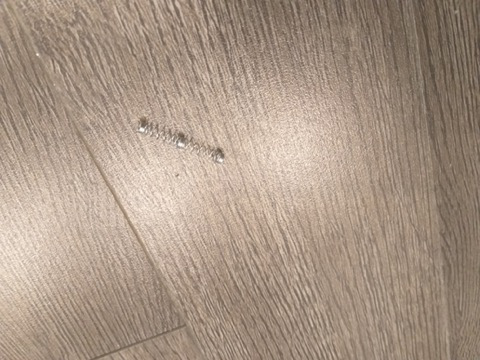

In [ ]:
from PIL import Image
image_path = sorted(list(paths.list_images('/content/Dataset_resized_2.0')))
print(len(image_path))
im = Image.open(image_path[10])
im

# Đường dẫn ảnh sẽ là dataset/tên_loại_rác/tên_ảnh ví dụ dataset-resized/Plastic/plastic209.jpg

In [ ]:
labels = [p.split(os.path.sep)[-2] for p in image_path]

# Chuyển tên các loại rác thành số

In [ ]:
le = LabelEncoder()
labels = le.fit_transform(labels)

In [ ]:
le.classes_

array(['G_M', 'Organic', 'Other', 'Paper', 'Plastic'], dtype='<U7')

# One-hot encoding

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

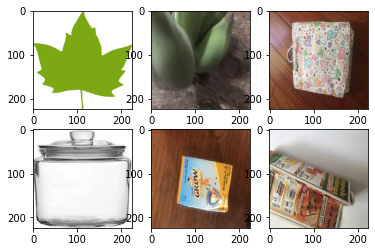

In [ ]:
from tensorflow.keras.preprocessing import image
for i, img_path in enumerate(random.sample(image_path, 6)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)

# Load ảnh và resize về đúng kích thước mà ResNet50 cần là (224,224)

In [ ]:
list_image = []
for (j, imagePath) in enumerate(image_path):
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, 0)
    image = imagenet_utils.preprocess_input(image)
    list_image.append(image)
list_image = np.vstack(list_image)

# Load model ResNet50, include_top=False để bỏ phần Fully connected layer

In [ ]:
IMG_SHAPE = (224,224,3)
base_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

# Freeze ResNet50 model

In [ ]:
from tensorflow.keras.layers import BatchNormalization

for layer in base_model.layers:
    layer.trainable = False
    if isinstance(layer, BatchNormalization):
        layer._per_input_updates = {}
len(base_model.layers)

190

# Xây dựng model 

In [ ]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.45),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 23,696,261
Trainable params: 131,461
Non-trainable params: 23,564,800
______________________________________

# Chia training set, test set tỉ lệ 80-20

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(list_image, labels, 
                                                    test_size=0.2, random_state=42)

In [ ]:
len(list_image)

3495

# Augmentation cho training data

In [ ]:
aug_train = ImageDataGenerator(rescale=1./255, rotation_range=30, 
                               width_shift_range=0.2, height_shift_range=0.2, 
                               shear_range=0.2, zoom_range=0.2, 
                               horizontal_flip=True, fill_mode='nearest')

# Augementation cho test data

In [ ]:
aug_test= ImageDataGenerator(rescale=1./255)

# Train lần đầu với các Freeze layer

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 30
steps_per_epoch = len(X_train)//32
validation_steps = len(X_test)//32
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

history = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=32), 
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs, 
                              workers=4,
                              validation_data=(aug_test.flow(X_test, y_test, batch_size=32)), 
                              validation_steps=validation_steps, callbacks=[callback])

<ipython-input-22-beefce75e873>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=32),


Epoch 1/30
87/87 [==============================] - 39s 302ms/step - loss: 1.6584 - accuracy: 0.3300 - val_loss: 1.1312 - val_accuracy: 0.5446
Epoch 2/30
87/87 [==============================] - 27s 298ms/step - loss: 1.2425 - accuracy: 0.4967 - val_loss: 0.9501 - val_accuracy: 0.6339
Epoch 3/30
87/87 [==============================] - 26s 291ms/step - loss: 1.0876 - accuracy: 0.5702 - val_loss: 0.8753 - val_accuracy: 0.6652
Epoch 4/30
87/87 [==============================] - 26s 288ms/step - loss: 1.0067 - accuracy: 0.5886 - val_loss: 0.8283 - val_accuracy: 0.6890
Epoch 5/30
87/87 [==============================] - 26s 284ms/step - loss: 0.9551 - accuracy: 0.6331 - val_loss: 0.7991 - val_accuracy: 0.6935
Epoch 6/30
87/87 [==============================] - 26s 286ms/step - loss: 0.9131 - accuracy: 0.6473 - val_loss: 0.7735 - val_accuracy: 0.7083
Epoch 7/30
87/87 [==============================] - 27s 305ms/step - loss: 0.8715 - accuracy: 0.6498 - val_loss: 0.7642 - val_accuracy: 0.7113

# Fine-tuning

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[fine_tune_at:]:
  layer.trainable =  True

Number of layers in the base model:  190


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 23,696,261
Trainable params: 20,691,333
Non-trainable params: 3,004,928
____________________________________

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
history_fine = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=32), 
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs, 
                              workers=4,
                              validation_data=(aug_test.flow(X_test, y_test, batch_size=32)), 
                              validation_steps=validation_steps, callbacks=[callback])

<ipython-input-26-c541bd954cd9>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_fine = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=32),


Epoch 1/30
87/87 [==============================] - 33s 299ms/step - loss: 0.8008 - accuracy: 0.6946 - val_loss: 0.6631 - val_accuracy: 0.7366
Epoch 2/30
87/87 [==============================] - 32s 351ms/step - loss: 0.6982 - accuracy: 0.7471 - val_loss: 0.6641 - val_accuracy: 0.7411
Epoch 3/30
87/87 [==============================] - 27s 305ms/step - loss: 0.6369 - accuracy: 0.7688 - val_loss: 0.6285 - val_accuracy: 0.7589
Epoch 4/30
87/87 [==============================] - 27s 301ms/step - loss: 0.5967 - accuracy: 0.7822 - val_loss: 0.5982 - val_accuracy: 0.7753
Epoch 5/30
87/87 [==============================] - 27s 301ms/step - loss: 0.5309 - accuracy: 0.8101 - val_loss: 0.5845 - val_accuracy: 0.7812
Epoch 6/30
87/87 [==============================] - 28s 308ms/step - loss: 0.5141 - accuracy: 0.8158 - val_loss: 0.5749 - val_accuracy: 0.7768
Epoch 7/30
87/87 [==============================] - 28s 309ms/step - loss: 0.4871 - accuracy: 0.8253 - val_loss: 0.5633 - val_accuracy: 0.7842

In [ ]:
model.save_weights('/content/drive/MyDrive/weights_resnet50v2.h5')

# Vẽ biểu đồ

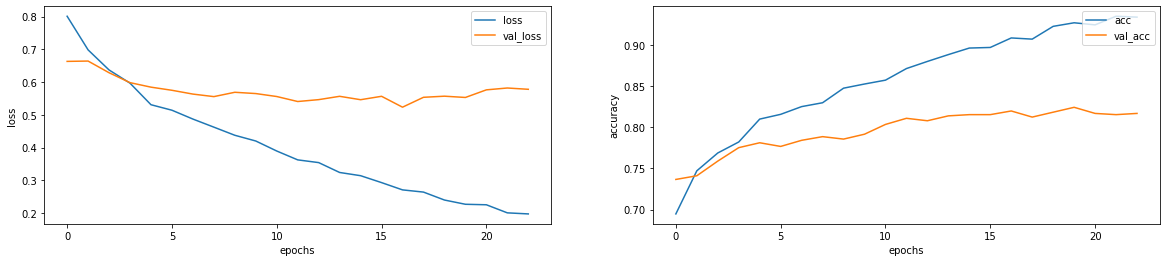

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))

axs[0].plot(history_fine.history['loss'], label='loss')
axs[0].plot(history_fine.history['val_loss'], label='val_loss')

axs[1].plot(history_fine.history['accuracy'], label='acc')
axs[1].plot(history_fine.history['val_accuracy'], label='val_acc')

axs.flat[0].set(xlabel='epochs', ylabel='loss')
axs.flat[1].set(xlabel='epochs', ylabel='accuracy')

for i,ax in enumerate(axs):
  axs[i].legend(loc="upper right")
plt.show()

#Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test/255.)
y_pred = le.classes_[np.argmax(pred, axis =1)]
y_true = le.classes_[np.argmax(y_test, axis =1)]
cd = confusion_matrix(y_true,y_pred)

22/22 [==============================] - 4s 133ms/step


In [ ]:
from sklearn.metrics import classification_report
target_names = ['G&M ', 'Other', 'Organic', 'Paper', 'Plastic']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        G&M        0.84      0.82      0.83       200
       Other       0.98      0.93      0.95        99
     Organic       0.82      0.77      0.79       199
       Paper       0.78      0.93      0.85       108
     Plastic       0.68      0.70      0.69        93

    accuracy                           0.82       699
   macro avg       0.82      0.83      0.82       699
weighted avg       0.82      0.82      0.82       699



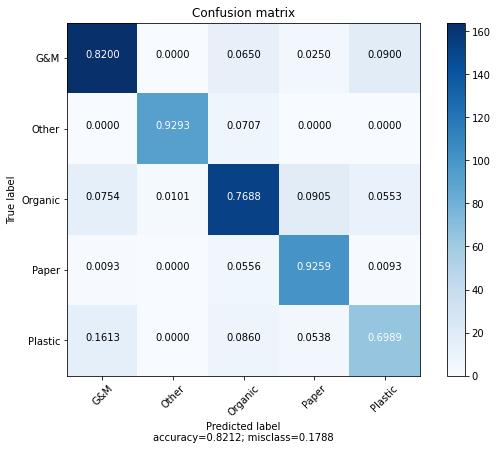

In [ ]:
plot_confusion_matrix(cd,
                      ['G&M', 'Other', 'Organic', 'Paper', 'Plastic'],
                      title='Confusion matrix',
                      cmap=None,
                      normalize=True)